<a href="https://www.kaggle.com/jasonjarosz/heart-disease-uci?scriptVersionId=88254735" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Source data & detailed info on the dataset: https://www.kaggle.com/ronitf/heart-disease-uci

This patient dataset includes 13 different medical features (age, gender, test results, etc.) along with whether or not the patient was diagnosed with heart disease. The goal of the analysis is to construct a predictive machine learning model using this data that can make a prediction of whether or not that patient has heart disease.

# **Table of Contents**

[Imports](#Imports)

[Initial EDA w/Pandas](#Initial-EDA-w/Pandas)

[Principal Component Analysis](#Principal-Component-Analysis)

[Logistic Regression without PCA](#Logistic-Regression-without-PCA)

[Logistic Regression with PCA](#Logistic-Regression-with-PCA)

[Logistic Regression: Results](#Logistic-Regression:-Results)

[Feature Selection w/Lasso Regression](#Feature-Selection-w/Lasso-Regression)

# Imports

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import recall_score, accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# This import & for loop are needed to access the data file on Kaggle
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heart-disease-uci/heart.csv


# Initial EDA w/Pandas

In [2]:
# Create DataFrame from .csv file
df = pd.read_csv('/kaggle/input/heart-disease-uci/heart.csv')

# Get an idea of what the data look like
print(df.head())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None


In [4]:
print(df.describe())

              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053  149.646865    0.326733    1.039604    1.399340    0.729373   
std      0.525860   22.9051

We can see that there are 12 feature columns and 1 target column. Some of the features may not be good predictors of our target and would just make the model noisier. We'll perform principal component analysis (PCA) to get some dimensionality reduction.

# Principal Component Analysis

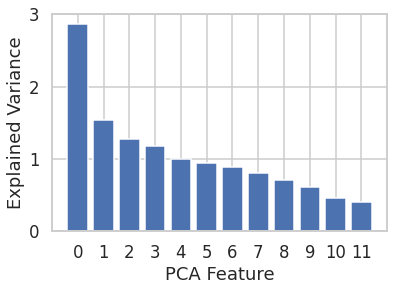

In [5]:
features = df.drop('target', axis=1)
target = df['target']

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.3,
                                                    random_state=1,
                                                    stratify=target)

# Standardize the data prior to PCA
scaler = StandardScaler()

# Fit on training set only
scaler.fit(X_train)

# Transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instantiate PCA instance that retains 95% of the variance
pca = PCA(0.95)
pca.fit(X_train_scaled)

# Plot the PCA features and variances
pca_features = range(pca.n_components_)

sns.set_theme('talk')
sns.set_style('whitegrid')

plt.bar(pca_features, pca.explained_variance_)
plt.xticks(pca_features)
plt.ylabel('Explained Variance')
plt.xlabel('PCA Feature')
plt.show()

PCA identified 12 features from the original 13. It looks like there is one component that is a very strong predictor of heart disease, but all play a part. It might be possible to drop PCA features 10 and 11, but we'll leave them for now.

In [6]:
# Transform the PCA data
X_train_pca_transformed = pca.transform(X_train_scaled)

# Logistic Regression without PCA

First, we'll build a logistic regression model *without* PCA as a baseline to compare against.

In [7]:
# Logistic regression model WITHOUT PCA
vanilla_log_reg = LogisticRegression()

# Create a list of C values to try
C_params = [i/20 for i in range(1, 21)]

# Set log reg parameters
params = {'C': C_params}

# Perform 10-fold GridSearchCV to find
vanilla_log_reg_gridcv = GridSearchCV(LogisticRegression(),
                                param_grid=params,
                                cv=10,
                                scoring='roc_auc',
                                return_train_score=True,
                                n_jobs=-1)

vanilla_log_reg_gridcv.fit(X_train_scaled, y_train)

# Scale the test data
X_test_scaled = scaler.transform(X_test)

y_pred = vanilla_log_reg_gridcv.predict(X_test_scaled)

print(f'Log reg best params: {vanilla_log_reg_gridcv.best_params_}')
print(f'Log reg accuracy score: {accuracy_score(y_test, y_pred)}\n')

# Print classification report
print(classification_report(y_test, y_pred))

Log reg best params: {'C': 0.15}
Log reg accuracy score: 0.8571428571428571

              precision    recall  f1-score   support

           0       0.85      0.83      0.84        41
           1       0.86      0.88      0.87        50

    accuracy                           0.86        91
   macro avg       0.86      0.85      0.86        91
weighted avg       0.86      0.86      0.86        91



# Logistic Regression with PCA

In [8]:
# Logistic regression model WITH PCA
vanilla_log_reg = LogisticRegression()

# Create a list of C values to try
C_params = [i/20 for i in range(1, 21)]

# Set log reg parameters
params = {'C': C_params}

# Perform 10-fold GridSearchCV to find
pca_log_reg_gridcv = GridSearchCV(LogisticRegression(),
                                  param_grid=params,
                                  cv=10,
                                  scoring='roc_auc',
                                  return_train_score=True,
                                  n_jobs=-1)

pca_log_reg_gridcv.fit(X_train_pca_transformed, y_train)

# Scale the test data
X_test_pca_transformed = pca.transform(X_test_scaled)

pca_y_pred = pca_log_reg_gridcv.predict(X_test_pca_transformed)

print(f'Log reg w/PCA best params: {pca_log_reg_gridcv.best_params_}')
print(f'Log reg w/PCA accuracy score: {accuracy_score(y_test, pca_y_pred)}\n')

# Print classification report
print(classification_report(y_test, pca_y_pred))

Log reg w/PCA best params: {'C': 0.05}
Log reg w/PCA accuracy score: 0.8351648351648352

              precision    recall  f1-score   support

           0       0.84      0.78      0.81        41
           1       0.83      0.88      0.85        50

    accuracy                           0.84        91
   macro avg       0.84      0.83      0.83        91
weighted avg       0.84      0.84      0.83        91



# Logistic Regression: Results

Interesting! The logistic regression model created using data that had PCA applied to it performed *worse* than the model without PCA. This means that it's likely the features of the original dataset all contribute to better predictions of the target class.

The lower accuracy score on the PCA log reg model is likely because there is always *some* amount of information loss when PCA is applied. When PCA is able to eliminate enough irrelevant features, it can result in a better model. But not here.

# Feature Selection w/Lasso Regression

Earlier in this analysis, I made a bar chart of explained variance per PCA feature. It showed that there was one feature in particular that explained a significant amount of the variance in the data compared to the rest. Let's figure out which feature it was with Lasso regression.

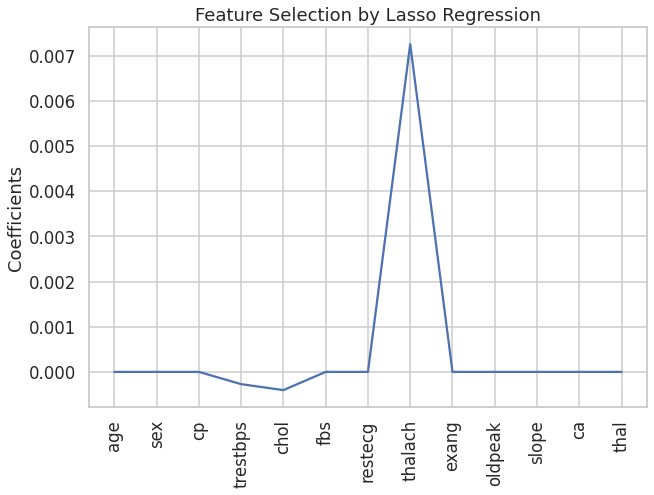

In [9]:
# Instantiate the model
lasso = Lasso()
lasso_coef = lasso.fit(features, target).coef_

# Create plot
names = df.drop('target', axis=1).columns
plt.figure(figsize=(10, 7))
plt.plot(range(len(names)), lasso_coef)
plt.xticks(range(len(names)), names, rotation=90)
plt.ylabel('Coefficients')
plt.title('Feature Selection by Lasso Regression')
plt.show()

The`thalach` column is the most important predictor of heart disease in the dataset. It describes the maximum heart rate achieved. Let's look at that column.

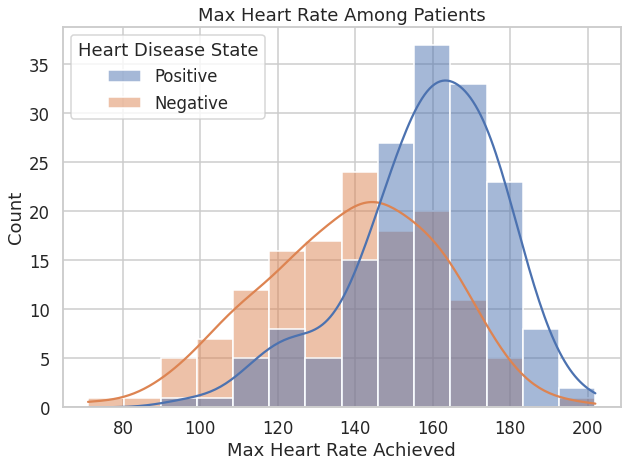

In [10]:
# Create target column that uses plain-english target names
df['Heart Disease State'] = df['target'].apply(lambda x: 'Positive' if x == 1 else 'Negative')

# Create hist/kde plot
plt.figure(figsize=(10, 7))
sns.histplot(data=df, x='thalach', hue='Heart Disease State', kde=True)
plt.title('Max Heart Rate Among Patients')
plt.xlabel('Max Heart Rate Achieved')
plt.show()

It definitely appears that patients with heart disease tend to have higher max heart rate when tested. Although, there is significant overlap between the two populations, reinforcing the fact that we need more than just a single feature to predict the presence of heart disease.